In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
import subprocess
from train_vae import train_vae, MNISTDataset
from vae import VAE
from mmd import MMD_3_Sample_Test

n_trials = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
f"{device = }"

"device = 'cuda'"

In [28]:
ds_name = "mnist"
in_dim = 784
latent_dim = 10
hidden_dim = 64

vae1_size = 5000
vae2_size_factors = [0.3, 0.5, 0.9, 1.1, 1.5, 2.0]
vae2_sizes = [int(vae1_size * size_factor) for size_factor in vae2_size_factors]

size_to_output_dir = lambda size, num: f"./mnist_{in_dim}_{latent_dim}_{hidden_dim}_{size}_{num}"

In [29]:
%reload_ext autoreload

In [30]:
# vae1
for i in range(n_trials):
    _ = train_vae(ds_name, in_dim, latent_dim, hidden_dim, vae1_size, device=device)
    subprocess.run(["python", "compute_accuracy.py", f"{size_to_output_dir(vae1_size, i)}"])

vae1_score = 0.
for i in range(n_trials):
    output_dir = size_to_output_dir(vae1_size, i)
    with open(f"{output_dir}/accuracy.txt") as file:
        vae1_score += float(next(iter(file))[:-1]) / n_trials

output_dir: ./mnist_784_10_64_5000_0
output_file: ./mnist_784_10_64_5000_0/accuracy.txt


In [31]:
# vae2
for vae2_size in vae2_sizes:
    for i in range(n_trials):
        _ = train_vae(ds_name, in_dim, latent_dim, hidden_dim, vae2_size, device=device)
        subprocess.run(["python", "compute_accuracy.py", f"{size_to_output_dir(vae2_size, i)}"])

vae2_scores = []
for vae2_size in vae2_sizes:
    score = 0
    for i in range(n_trials):
        output_dir = size_to_output_dir(vae2_size, i)
        with open(f"{output_dir}/accuracy.txt") as file:
            score += float(next(iter(file))[:-1]) / n_trials
    vae2_scores.append(score)

output_dir: ./mnist_784_10_64_1500_0
output_file: ./mnist_784_10_64_1500_0/accuracy.txt
output_dir: ./mnist_784_10_64_2500_0
output_file: ./mnist_784_10_64_2500_0/accuracy.txt
output_dir: ./mnist_784_10_64_4500_0
output_file: ./mnist_784_10_64_4500_0/accuracy.txt
output_dir: ./mnist_784_10_64_5500_0
output_file: ./mnist_784_10_64_5500_0/accuracy.txt
output_dir: ./mnist_784_10_64_7500_0
output_file: ./mnist_784_10_64_7500_0/accuracy.txt
output_dir: ./mnist_784_10_64_10000_0
output_file: ./mnist_784_10_64_10000_0/accuracy.txt


In [33]:
n_samples = 2000
X = MNISTDataset(train=False).data

In [36]:
import numpy as np
for vae2_size in vae2_sizes:
    print(vae1_size, vae2_size)
    for i in range(n_trials):
        vae1 = VAE(in_dim, latent_dim, hidden_dim)
        vae1.load_state_dict(torch.load(size_to_output_dir(vae1_size, i) + "/checkpoint.pt", map_location=device))
        vae2 = VAE(in_dim, latent_dim, hidden_dim)
        vae2.load_state_dict(torch.load(size_to_output_dir(vae2_size, i) + "/checkpoint.pt", map_location=device))
        idcs = np.random.randint(X.shape[0], size=n_samples)
        Y = vae1.sample(n_samples).cpu().numpy()
        Z = vae2.sample(n_samples).cpu().numpy()
        print(MMD_3_Sample_Test(X[idcs], Y, Z))

5000 1500


(1.0, -33.76707913762656, 18.04827208283377, None, None)
5000 2500
(1.0, -21.459638047689328, 18.076452368361675, None, None)
5000 4500
(0.9999999985993719, -5.942840131252328, 18.070963405180933, None, None)
5000 5500
(0.006563808438106312, 2.4802883627588637, 18.18466123033437, None, None)
5000 7500
(9.94762269708844e-62, 16.536915346353176, 18.184910088335723, None, None)
5000 10000
(1.3810688007539785e-153, 26.37346893763353, 18.302347724164473, None, None)


Text(0.5, 0, 'Ratio Training Samples for Encoder 2 and Training Samples Encoder 1')

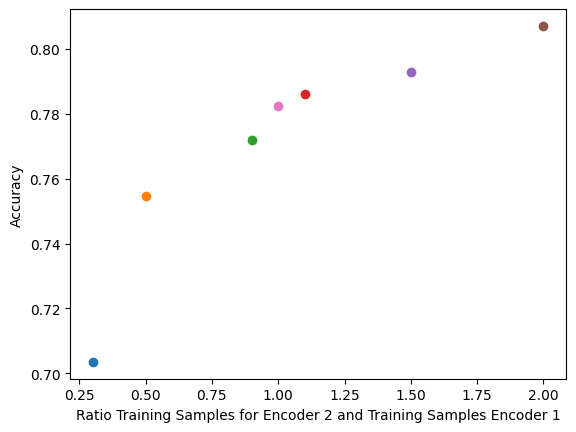

In [39]:
import matplotlib.pyplot as plt
for vae2_size_factor, vae2_score in zip(vae2_size_factors, vae2_scores):
    plt.plot([vae2_size_factor], [vae2_score], "o")
plt.hline(vae1_score, xmin=min(vae2_size_factors), xmax=max(vae2_size_factors))
plt.ylabel("Accuracy")
plt.xlabel("Ratio Training Samples for Encoder 2 and Training Samples Encoder 1")